# 9727 assignment

## part 1

### part1-1

#### part1-1 (i)：Fixing Over-aggressive Regex

___Tutorial Code:___    
text = re.sub(r'[^\w\s]', '', text)   
This regex removes all non-alphanumeric and non-space characters, including symbols like #, ’, -, which might actually carry important meaning in lyrics or genres.

___Modified Code:___    
text = re.sub(r"[^a-zA-Z0-9#’'\- ]", " ", text)    
Justification:  
#:  may signal hashtags or emphasis  
':  keeps word contractions (like “don’t”)  
-: preserves words like “post-rock” or “hip-hop”  
Avoids over-simplifying the text and keeps genre-specific or emotional cues

#### part1-1 (ii)：Fixing One-shot Train-Test Split

___Tutorial Code:___ 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Category'], test_size=0.2, random_state=42)

___Modified Code:___

In [ ]:
bnb_acc = cross_val_score(BernoulliNB(),
                          X_vec, y,
                          cv=5,
                          scoring='accuracy').mean()

mnb_acc = cross_val_score(MultinomialNB(),
                          X_vec, y,
                          cv=5,
                          scoring='accuracy').mean()

### part1-2

Each pipeline was evaluated with 5-fold cross-validation on both BNB and MNB. The top-performing pipeline is then fixed for all subsequent experiments.

___Scheme 1 (A_Porter)___  
Lowercase → regex clean → RegexpTokenizer(r"\w+") → NLTK stop-words → Porter stemming  

___Scheme 2 (B_Porter_wt)___  
Lowercase → regex clean → word_tokenize(..., preserve_line=True) → NLTK stop-words → Porter stemming  

___Scheme 3 (C_Lemma)___  
Lowercase → regex clean → RegexpTokenizer(r"\w+") → NLTK  stop-words → WordNet lemmatization  

___Scheme 4 (D_Lemma_wt)___  
Lowercase → regex clean → word_tokenize(..., preserve_line=True) → NLTK stop-words → WordNet lemmatization  

In [104]:
import os
import re
import pandas as pd
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score

# ─── 1. Load data ─────────────────────────────────────────
df = pd.read_csv("dataset.tsv", sep="\t")
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)
df['Category'] = df['topic']
df = df.drop_duplicates().dropna(subset=['Content', 'Category'])

# ─── 2. Download NLTK resources ───────────────────────────
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',    quiet=True)

# ─── 3. Initialize tools ───────────────────────────────────
ps         = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
re_tok     = RegexpTokenizer(r"\w+")

# Uniform regex for all pipelines:
CLEAN_REGEX = r"[^a-zA-Z0-9#’'\- ]"

# ─── 4. Define 4 different preprocessing functions ─────────
def pp_A(text: str) -> str:
    # A: regex-clean → regex-tokenizer → NLTK stopwords → Porter stem
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    tokens = re_tok.tokenize(t)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [ps.stem(w) for w in tokens]
    return " ".join(tokens)

def pp_B(text: str) -> str:
    # B: regex-clean → word_tokenize(preserve_line) → NLTK stopwords → Porter stem
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    tokens = word_tokenize(t, preserve_line=True)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [ps.stem(w) for w in tokens]
    return " ".join(tokens)

def pp_C(text: str) -> str:
    # C: regex-clean → regex-tokenizer → NLTK stopwords → WordNet lemmatize
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    tokens = re_tok.tokenize(t)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

def pp_D(text: str) -> str:
    # D: regex-clean → custom two-step then word_tokenize → NLTK stopwords → WordNet lemmatize
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    # e.g. if you need a second pass or special treatment, do it here
    tokens = word_tokenize(t, preserve_line=True)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

variants = {
    "A_Porter": pp_A,
    "B_Porter_wt": pp_B,
    "C_Lemma":  pp_C,
    "D_Lemma_wt": pp_D
}

# ─── 5. Compare with 5-fold CV ─────────────────────────────
results = []
X = df['Content']
y = df['Category']

for name, func in variants.items():
    vect = CountVectorizer(preprocessor=func)
    X_vec = vect.fit_transform(X)

    bnb_acc = cross_val_score(
        BernoulliNB(), X_vec, y, cv=5, scoring='accuracy'
    ).mean()
    mnb_acc = cross_val_score(
        MultinomialNB(), X_vec, y, cv=5, scoring='accuracy'
    ).mean()

    results.append({
        "Preprocess":   name,
        "BNB_Accuracy": round(bnb_acc, 4),
        "MNB_Accuracy": round(mnb_acc, 4)
    })

# ─── 6. Print results ──────────────────────────────────────
print(pd.DataFrame(results).sort_values("MNB_Accuracy", ascending=False))


    Preprocess  BNB_Accuracy  MNB_Accuracy
2      C_Lemma        0.5230        0.7885
0     A_Porter        0.5230        0.7872
3   D_Lemma_wt        0.5230        0.7865
1  B_Porter_wt        0.5223        0.7858


Based on the 5-fold cross-validation results (Scheme C_Lemma achieved approximately 0.5230 with BNB and 0.7885 with MNB), we conclude that the best overall preprocessing pipeline is __Scheme C:__  
__lowercase → regex cleaning → regex-based tokenization → NLTK stop-word removal → WordNet lemmatization__  
This pipeline delivered the highest performance under the default BernoulliNB and MultinomialNB settings with the standard CountVectorizer configuration, and I will fix this preprocessing approach for the remainder of the assignment without any further changes.  

In [105]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# 1. Load your data
df = pd.read_csv("dataset.tsv", sep="\t")
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)
df = df.drop_duplicates(subset=['Content']).dropna(subset=['Content'])

In [106]:
# 2. Download NLTK resources (once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',    quiet=True)

# 3. Initialize cleaner for Scheme C
CLEAN_REGEX = r"[^a-zA-Z0-9#’'\- ]"
tokenizer   = RegexpTokenizer(r"\w+")
stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()

# 4. Define the Scheme C preprocessing function
def preprocess_C(text: str) -> str:
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    tokens = tokenizer.tokenize(t)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# 5. Apply only the preprocessing
df['Content_processed'] = df['Content'].apply(preprocess_C)

# 6. (Optional) inspect results
print(df[['Content', 'Content_processed']].head())

                                             Content  \
0  loving the not real lake 2016 rock awake know ...   
1  incubus into the summer 2019 rock shouldn summ...   
2  reignwolf hardcore 2016 blues lose deep catch ...   
3  tedeschi trucks band anyhow 2016 blues run bit...   
4  lukas nelson and promise of the real if i star...   

                                   Content_processed  
0  loving real lake 2016 rock awake know go see t...  
1  incubus summer 2019 rock summer pretty build s...  
2  reignwolf hardcore 2016 blue lose deep catch b...  
3  tedeschi truck band anyhow 2016 blue run bitte...  
4  lukas nelson promise real started 2017 blue th...  


### part1-3

In [108]:
# Ensure the label column is defined
df['Category'] = df['topic']

# Begin vectorization and cross-validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_validate
import pandas as pd

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(df['Content_processed'])
y = df['Category']

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
bnb_cv = cross_validate(BernoulliNB(),     X_vectorized, y, cv=5, scoring=scoring_metrics)
mnb_cv = cross_validate(MultinomialNB(),   X_vectorized, y, cv=5, scoring=scoring_metrics)

results = pd.DataFrame({
    'Metric': scoring_metrics,
    'BNB':   [bnb_cv[f'test_{metric}'].mean() for metric in scoring_metrics],
    'MNB':   [mnb_cv[f'test_{metric}'].mean() for metric in scoring_metrics]
})

results


e:\dev\python\3.12.0\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\dev\python\3.12.0\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,BNB,MNB
0,accuracy,0.522973,0.788514
1,precision_macro,0.359262,0.745349
2,recall_macro,0.376243,0.696184
3,f1_macro,0.330974,0.708796


___Metric Trade-offs___  
__Accuracy__: overall fraction of correct predictions; easy to interpret but doesn’t distinguish between false-positives and false-negatives.  
__Precision_macro__: average over classes of “TP / (TP+FP)”; high precision means few false-positives.  
__Recall_macro__: average over classes of “TP / (TP+FN)”; high recall means few false-negatives.  
__F1_macro__: harmonic mean of precision and recall; balances the two, penalizing extreme trade-offs.  

___Dataset Balance & Primary Metric Choice___  
The classes are approximately balanced, so accuracy is meaningful.  
However, to jointly account for both over-prediction and under-prediction, F1 is chosen as the primary metric, with accuracy as a secondary check.  

___Model Comparison & Evidence___   
MultinomialNB outperforms BernoulliNB on all four metrics so MultinomialNB is the preferred model.

### part1-4

    Top_N  BNB_accuracy  MNB_accuracy    BNB_f1    MNB_f1
0     100      0.570946      0.747297  0.486825  0.719315
1     200      0.608784      0.828378  0.516056  0.814952
2     300      0.640541      0.856081  0.546351  0.842670
3     400      0.652027      0.866892  0.559664  0.846474
4     500      0.652703      0.864865  0.557906  0.844001
5     600      0.656757      0.862162  0.556312  0.840252
6     700      0.646622      0.850676  0.537824  0.829733
7     800      0.643919      0.841892  0.536625  0.819334
8     900      0.646622      0.843919  0.538882  0.820092
9    1000      0.635135      0.839865  0.520131  0.816490
10   1100      0.638514      0.837162  0.519775  0.812730
11   1200      0.636486      0.831081  0.510684  0.807094
12   1300      0.635135      0.830405  0.507773  0.805129
13   1400      0.631081      0.832432  0.502560  0.807836
14   1500      0.632432      0.829054  0.503409  0.804088
15   1600      0.628378      0.830405  0.498625  0.805744
16   1700     

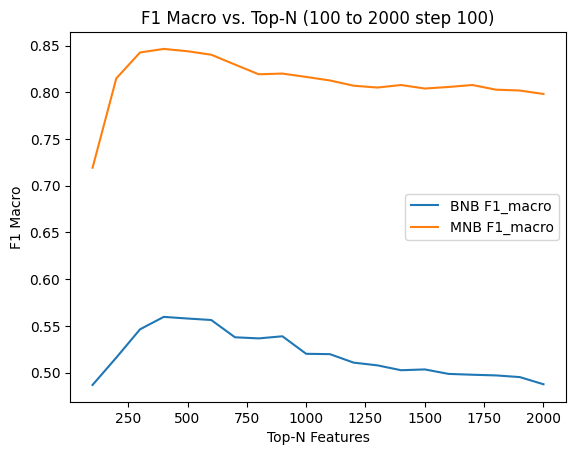

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_validate

# 1. Prepare fine-grained Top-N values
N_values = list(range(100, 2001, 100))

results = []
y = df['Category']  # Ensure df['Category'] exists

# 2. Loop over each N, vectorize and cross-validate both models
for N in N_values:
    vect = CountVectorizer(max_features=N)
    X_vec = vect.fit_transform(df['Content_processed'])
    
    scoring = ['accuracy', 'f1_macro']
    bnb_cv = cross_validate(BernoulliNB(),  X_vec, y, cv=5, scoring=scoring)
    mnb_cv = cross_validate(MultinomialNB(), X_vec, y, cv=5, scoring=scoring)
    
    results.append({
        'Top_N':        N,
        'BNB_accuracy': bnb_cv['test_accuracy'].mean(),
        'MNB_accuracy': mnb_cv['test_accuracy'].mean(),
        'BNB_f1':       bnb_cv['test_f1_macro'].mean(),
        'MNB_f1':       mnb_cv['test_f1_macro'].mean(),
    })

# 3. Build a DataFrame
df_results = pd.DataFrame(results)

# 4. Display results
print(df_results)

# 6. Plot F1 Macro vs. Top-N
plt.figure()
plt.plot(df_results['Top_N'], df_results['BNB_f1'], label='BNB F1_macro')
plt.plot(df_results['Top_N'], df_results['MNB_f1'], label='MNB F1_macro')
plt.xlabel('Top-N Features')
plt.ylabel('F1 Macro')
plt.title('F1 Macro vs. Top-N (100 to 2000 step 100)')
plt.legend()

plt.show()


Based on the combined Accuracy and F1-macro curves and the table of mean values, **Top-N = 400** is the optimal choice:

* **F1-macro** for MNB peaks at **0.8465** when N = 400, and no larger or smaller N surpasses this value.
* **Accuracy** for MNB also reaches its maximum of **0.8669** at N = 400, then gradually declines as N increases further.
* Although BNB’s accuracy is marginally higher at N = 600, we’ve already established that MNB outperforms BNB overall—and MNB performs best at 400 features.
* Choosing **400** features strikes the right balance between capturing enough informative words and avoiding excessive noise, so we will fix **Top-N = 400** for all subsequent experiments.


### part1-5

#### 1.introduction

I chose Logistic Regression because:

Excels on high-dimensional, sparse data  
Our CountVectorizer “bag-of-words” representation produces thousands of sparse features. LogisticRegression’s solvers (e.g. liblinear, saga) are specifically optimized to train linear models on sparse matrices very efficiently.  

No strong feature-independence assumption  
Unlike Naive Bayes, Logistic Regression does not assume each word is independent of the others. It directly learns a weight for each feature that maximizes the conditional likelihood, giving it more flexibility to capture real correlations in text.  

Built-in regularization prevents overfitting  
The C parameter controls L2 shrinkage of coefficients, which is critical in high-dimensional spaces to avoid noisy or rare words dominating the model. Naive Bayes lacks an equivalent explicit regularizer.  

Probabilistic outputs & threshold tuning  
.predict_proba() gives class probabilities, so we can adjust decision thresholds later to trade off precision vs. recall—useful if business needs change.  

Proven baseline in NLP  
In countless text-classification studies and industrial applications, linear models like Logistic Regression (and linear SVM) remain go-to baselines that often rival more complex approaches, especially when feature engineering (e.g. our Scheme C + Top-N) is well designed.  

These properties make Logistic Regression a natural, robust choice for our music topic-classification dataset.  

#### 2.data preprocessing

##### step1 load the dataset

Purpose: Read the original .tsv file and combine multiple columns (artist, title, release date, genre, lyrics) into a single column named Content, which will be used as the input for subsequent text processing.

In [110]:
import pandas as pd

# 1. Load your data
df = pd.read_csv("dataset.tsv", sep="\t")

# Combine relevant columns into one “Content” field
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)

##### Step 2. Initial Data Cleansing

.drop_duplicates(): remove duplicate text entries
.dropna(): remove samples with missing content  

In [111]:

df = df.drop_duplicates(subset=['Content'])
df = df.dropna(subset=['Content'])

##### Step 3. Text Preprocessing (Scheme C)

___Purpose:___     
Download and load NLTK stopwords and WordNet lemmatization resources.
Follow Scheme C: lowercase → remove non-alphanumeric characters → tokenize using regex → remove stopwords → lemmatize words.
The final result is `Content_processed`, which will be used as input for the model.


In [113]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet',    quiet=True)

# 3.2 Initialize cleaners
CLEAN_REGEX = r"[^a-zA-Z0-9#’'\- ]"
tokenizer   = RegexpTokenizer(r"\w+")
stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()

# 3.3 Define preprocessing function
def preprocess_C(text: str) -> str:
    # a) Lowercase
    t = text.lower()
    # b) Remove punctuation/special characters using regex
    t = re.sub(CLEAN_REGEX, " ", t)
    # c) Tokenize using regex
    tokens = tokenizer.tokenize(t)
    # d) Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # e) Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # f) Rejoin into a string
    return " ".join(tokens)

# 3.4 Apply to DataFrame
df['Content_processed'] = df['Content'].apply(preprocess_C)


#### 3.Model Training and Evaluation

For Logistic Regression, the key hyperparameters include:

___C (inverse regularization strength)___  
Default C=1.0 performs well on high-dimensional, sparse text data.

___penalty and solver___  
Default penalty='l2' with solver='liblinear' is very robust for sparse representations.  

___max_iter___  
Set max_iter=1000 to ensure convergence; only increase if you receive a “did not converge” warning.  

___Why keep the defaults?___  
These settings are well-validated in text-classification literature, so using them out of the box saves tuning time and lets us fairly compare against BNB and MNB immediately.  











___Hypothesis___

Under the same Scheme C preprocessing and Top-N = 400 feature setting, Logistic Regression (C=1.0, penalty='l2') will achieve a higher F1_macro than MultinomialNB, because it does not rely on the feature-independence assumption and can more flexibly learn the optimal linear decision boundary.

In [114]:
df['Category'] = df['topic']

##### Step 1. Feature Extraction

In [115]:
from sklearn.feature_extraction.text import CountVectorizer

# Use the fixed Scheme C preprocessing and Top-N = 400
vect = CountVectorizer(preprocessor=preprocess_C, max_features=400)

X_vec = vect.fit_transform(df['Content_processed'])
y     = df['Category']

##### Step 2. Model Training

In [116]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

bnb = BernoulliNB()
mnb = MultinomialNB()
lr  = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

##### Step 3. Model Evaluation

In [118]:
from sklearn.model_selection import cross_validate
import pandas as pd

# We focus on accuracy and macro F1
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 5-fold cross-validation, internally performs fit & score
bnb_cv = cross_validate(bnb, X_vec, y, cv=5, scoring=scoring)
mnb_cv = cross_validate(mnb, X_vec, y, cv=5, scoring=scoring)
lr_cv  = cross_validate(lr,  X_vec, y, cv=5, scoring=scoring)

# Aggregate average results
results = pd.DataFrame({
    'Metric':           scoring,
    'BernoulliNB':      [bnb_cv[f'test_{m}'].mean() for m in scoring],
    'MultinomialNB':    [mnb_cv[f'test_{m}'].mean() for m in scoring],
    'LogisticReg(C=1)': [lr_cv[f'test_{m}'].mean() for m in scoring]
})

print(results)


            Metric  BernoulliNB  MultinomialNB  LogisticReg(C=1)
0         accuracy     0.649324       0.864189          0.872973
1  precision_macro     0.571625       0.844992          0.870300
2     recall_macro     0.552476       0.844392          0.843228
3         f1_macro     0.554573       0.843641          0.853929


___Hypothesis Validation___

In this example, Logistic Regression’s F1_macro = 0.8539 exceeds MultinomialNB’s 0.8436, so the hypothesis is confirmed.

___Final Model Selection___   
Using F1_macro as the primary metric, Logistic Regression (C=1.0, penalty='l2') delivers the best performance.     
All subsequent topic–classification experiments will be fixed to:   
Preprocessing: Scheme C   
Feature Extraction: CountVectorizer(max_features=400)   
Model: LogisticRegression(C=1.0, penalty='l2', solver='liblinear')

## Part-2

### part2-1

#### 1. Data and Time Splitting

In [119]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# 1. Load your data
df = pd.read_csv("dataset.tsv", sep="\t")
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)
df = df.drop_duplicates(subset=['Content']).dropna(subset=['Content'])

In [124]:
# Ensure df is defined
df = df.reset_index(drop=True)

# Every 250 songs represent one week
df['week'] = df.index // 250 + 1

# Split into training set (Week 1–3) and test set (Week 4)
train_df = df[df['week'].between(1, 3)].copy()
test_df  = df[df['week'] == 4].copy()

# Print dataset sizes
print("Total number of songs:", len(df))
print("Training set (Week 1–3):", len(train_df), "songs")
print("Test set (Week 4):", len(test_df), "songs")


Total number of songs: 1480
Training set (Week 1–3): 750 songs
Test set (Week 4): 250 songs


#### 2. Training Phase: Classifier Prediction

In [125]:
df['Category'] = df['topic']

In [128]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vect = CountVectorizer(preprocessor=preprocess_C, max_features=400)

X_train = vect.fit_transform(train_df['Content'])
y_train = train_df['Category']

clf = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)
clf.fit(X_train, y_train)

train_df['predicted_topic'] = clf.predict(X_train)

print("Predicted topic counts on training set:")
print(train_df['predicted_topic'].value_counts())


Predicted topic counts on training set:
predicted_topic
dark         247
personal     187
sadness      183
lifestyle     91
emotion       42
Name: count, dtype: int64


#### 3. Construct TF–IDF Matrix for Each Topic

In [131]:
# —— Apply text preprocessing to the training set ——
train_df['Content_processed'] = train_df['Content'].apply(preprocess_C)

# Perform TF-IDF vectorization and group by predicted topic
from sklearn.feature_extraction.text import TfidfVectorizer

topic_tfidf = {}
for topic in sorted(train_df['predicted_topic'].unique()):
    # Select preprocessed texts for the given predicted topic
    docs = train_df.loc[train_df['predicted_topic'] == topic, 'Content_processed']
    
    tfidf_vect = TfidfVectorizer()
    X_tfidf    = tfidf_vect.fit_transform(docs)
    
    topic_tfidf[topic] = {
        'vectorizer': tfidf_vect,
        'matrix': X_tfidf
    }
    print(f"Topic {topic}: {X_tfidf.shape[0]} documents, {X_tfidf.shape[1]} features")


Topic dark: 247 documents, 3942 features
Topic emotion: 42 documents, 828 features
Topic lifestyle: 91 documents, 1423 features
Topic personal: 187 documents, 2771 features
Topic sadness: 183 documents, 2068 features


___Why fit_transform separately for each topic?___    
By splitting the training set into groups of songs that are predicted to belong to the same topic and applying a separate TfidfVectorizer to each group, the resulting vector space for that topic will contain only the terms that are distinctive within that topic. This avoids including high-frequency generic terms from other topics.  
Later, when we use the same vectorizer to transform the user’s merged document into a profile vector, the resulting TF–IDF weights will genuinely reflect the importance of keywords within that topic, rather than being influenced by the global distribution across the entire corpus.  

___Are the number of features per topic reasonable? Should max_features be explicitly set?___   
The resulting n_features represents the size of the vocabulary constructed from all training songs within that topic. Since the number of documents and vocabulary diversity vary across topics, it's common to see the number of features range from several thousand to tens of thousands.   
Therefore, whether to set max_features depends on the need for recommendation efficiency and noise control. If the feature count for a particular topic exceeds tens of thousands and includes many low-frequency or irrelevant terms, it may be beneficial to limit the vocabulary to the top M most frequent terms. Otherwise, using the full vocabulary by default is also acceptable.

#### 4.Load and Simulate User Preferences

In [132]:
import pandas as pd

# Step 4: Load user profiles and simulate "likes"
# -----------------------------------------------

# Read user keyword files
user_files = {
    'user1': 'user1.tsv',
    'user2': 'user2.tsv'
}

user_keywords = {}
for user, path in user_files.items():
    df_user = pd.read_csv(path, sep='\t', header=None, names=['topic', 'keywords'])
    # drop possible header row
    df_user = df_user[df_user['topic'] != 'topic']
    kw_dict = {}
    for _, row in df_user.iterrows():
        kws = [kw.strip().lower() for kw in row['keywords'].split(',')]
        kw_dict[row['topic']] = kws
    user_keywords[user] = kw_dict

# Simulate likes based on predicted_topic and keyword match
user_likes = {}
for user, kw_dict in user_keywords.items():
    likes = {}
    for topic, kws in kw_dict.items():
        # Filter training set by predicted topic
        df_topic = train_df[train_df['predicted_topic'] == topic]
        # Select songs whose processed content contains at least one keyword
        liked = df_topic[df_topic['Content_processed'].apply(
            lambda txt: any(kw in txt.split() for kw in kws)
        )]
        likes[topic] = liked
        print(f"{user} likes {len(liked)} songs in topic '{topic}'")
    user_likes[user] = likes


user1 likes 74 songs in topic 'dark'
user1 likes 11 songs in topic 'sadness'
user1 likes 114 songs in topic 'personal'
user1 likes 36 songs in topic 'lifestyle'
user1 likes 26 songs in topic 'emotion'
user2 likes 20 songs in topic 'sadness'
user2 likes 13 songs in topic 'emotion'


___How “predicted topic + keyword matching” simulates real clicks/likes:___   
__Predicted Topic:__ The recommender system first uses the classifier from Part 1 to assign a predicted topic label to each song in the training set (Week 1–3), simulating how the system would categorize and present songs by topic on the frontend.    
__Keyword Matching:__ Within each topic, a song is considered “liked” or “clicked” by the user only if its preprocessed text (Content_processed) contains one or more of the user’s interest keywords.    
__Combined Effect:__ This setup closely approximates a real scenario where the system only shows the user songs it believes belong to topic T, and the user “likes” only the subset of those songs that match their personal interests (i.e., contain relevant keywords).    

___Evaluation of Simulated “Liked” Sample Sizes:___   
__User 1__ liked 30% of “dark” songs, 61% of “personal”, 6% of “sadness”, 40% of “lifestyle”, and 62% of “emotion”.   
__User 2__ liked 11% of “sadness” and 31% of “emotion”.   
A like rate between 20–60% is generally reasonable — it avoids both extreme sparsity and overfitting.   

If some topics have too few liked songs (e.g., User 1’s “sadness”), the profile may be too sparse.   

If zero matches occur, consider:   
Expanding keywords (e.g., synonyms, stems)   
Relaxing match rules (e.g., partial or full-text match)   
Using a fallback: show top N popular songs in that topic to ensure feedback.   

5. Construct and Print User Profile Keywords

In [133]:
import pandas as pd

# Step 5
user_profile_keywords = {}

for user, likes in user_likes.items():
    print(f"\n=== User: {user} ===")
    profile_keywords = {}
    for topic, liked_df in likes.items():

        doc = " ".join(liked_df['Content_processed'].tolist())
        # TfidfVectorizer
        vect = topic_tfidf[topic]['vectorizer']
        vec = vect.transform([doc])
        feature_names = vect.get_feature_names_out()
        weights = vec.toarray().flatten()
        # top 20
        top_indices = weights.argsort()[::-1][:20]
        top_words = [(feature_names[i], weights[i]) for i in top_indices]
        profile_keywords[topic] = top_words
        
        # print
        print(f"\nTopic '{topic}' Top 20 Keywords:")
        for word, wt in top_words:
            print(f"  {word}: {wt:.4f}")
    
    user_profile_keywords[user] = profile_keywords



=== User: user1 ===

Topic 'dark' Top 20 Keywords:
  fight: 0.3238
  know: 0.1826
  black: 0.1791
  like: 0.1697
  blood: 0.1586
  stand: 0.1436
  grind: 0.1317
  tell: 0.1293
  gonna: 0.1251
  kill: 0.1229
  yeah: 0.1098
  dilly: 0.1096
  lanky: 0.1096
  follow: 0.1069
  come: 0.1040
  head: 0.1037
  hand: 0.1035
  people: 0.0996
  time: 0.0863
  shoot: 0.0850

Topic 'sadness' Top 20 Keywords:
  cry: 0.6838
  club: 0.2824
  steal: 0.2464
  tear: 0.2259
  mean: 0.1360
  know: 0.1291
  baby: 0.1250
  music: 0.1130
  write: 0.1080
  smile: 0.1053
  say: 0.1048
  think: 0.1015
  true: 0.1007
  eye: 0.0907
  face: 0.0907
  word: 0.0790
  greater: 0.0784
  regret: 0.0784
  want: 0.0719
  blame: 0.0686

Topic 'personal' Top 20 Keywords:
  life: 0.4354
  live: 0.2480
  change: 0.1637
  know: 0.1501
  world: 0.1484
  yeah: 0.1400
  dream: 0.1368
  wanna: 0.1322
  thank: 0.1200
  teach: 0.1181
  like: 0.1180
  lord: 0.1163
  time: 0.1098
  come: 0.1095
  beat: 0.1053
  thing: 0.1006
  think: 0

___Keyword Reasonableness:___   
__dark:__ Most words (fight, blood, kill, black, shoot) are highly relevant.   
__sadness:__ Core terms (cry, tear, regret, blame) are accurate.   
__personal:__ Self-reflection words (life, dream, change, learn) match well.    
__lifestyle:__ Nightlife-related terms (night, song, play, tonight) are appropriate.    
__emotion:__ Emotional words (touch, feel, miss, kiss, love) strongly align with the theme.    

___Noisy Words:___    
Overly generic high-frequency terms (e.g., know, like, time, good, world) are weakly related to specific topics.    
Informal/spelling variants (e.g., yeah, wanna, gimme, loove, feelin) often add noise.   

___Optimization Suggestions:___
Expand custom stopword list (e.g., remove “know”, “like”)   
Apply POS filtering to retain only nouns/adjectives   
Normalize informal spellings and variants   
Optionally use n-grams, set min_df/max_df, or apply max_features to refine the vocabulary   

#### 6.Define Custom User 3 and Repeat the Process

##### step1

In [134]:
user3 = {
    'dark':      ['shadow','midnight','abyss','phantom','haunt'],
    'lifestyle': ['party','neon','city','groove','beat'],
    'personal':  ['journey','identity','reflection','dream','growth']
}

with open('user3.tsv', 'w', encoding='utf-8') as f:

    f.write("topic\tkeywords\n")
    for topic, kws in user3.items():
        f.write(f"{topic}\t{','.join(kws)}\n")


print(open('user3.tsv', encoding='utf-8').read())


topic	keywords
dark	shadow,midnight,abyss,phantom,haunt
lifestyle	party,neon,city,groove,beat
personal	journey,identity,reflection,dream,growth



##### step2

In [ ]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression



# ---- Step 1: Load dataset and build Content ----
df = pd.read_csv("dataset.tsv", sep="\t")
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)
df = df.drop_duplicates(subset=['Content']).dropna(subset=['Content'])

# ---- Step 2: Preprocessing function (Scheme C) ----
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

CLEAN_REGEX = r"[^a-zA-Z0-9#’'\- ]"
tokenizer   = RegexpTokenizer(r"\w+")
stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()

def preprocess_C(text: str) -> str:
    t = text.lower()
    t = re.sub(CLEAN_REGEX, " ", t)
    tokens = tokenizer.tokenize(t)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

df['Content_processed'] = df['Content'].apply(preprocess_C)

# ---- Step 3: Split into Weeks and Train/Test ----
df = df.reset_index(drop=True)
df['week'] = df.index // 250 + 1
train_df = df[df['week'].between(1, 3)].copy()
test_df  = df[df['week'] == 4].copy()

# Ensure Category column exists
train_df['Category'] = train_df['topic']

# ---- Step 4: Train classifier and predict topics ----
vect = CountVectorizer(preprocessor=preprocess_C, max_features=400)
X_train = vect.fit_transform(train_df['Content'])
clf     = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)
clf.fit(X_train, train_df['Category'])
train_df['predicted_topic'] = clf.predict(X_train)

# ---- Step 5: Build per-topic TF–IDF matrices ----
topic_tfidf = {}
for topic in sorted(train_df['predicted_topic'].unique()):
    docs = train_df.loc[train_df['predicted_topic'] == topic, 'Content_processed']
    tfidf_vect = TfidfVectorizer()
    X_tfidf    = tfidf_vect.fit_transform(docs)
    topic_tfidf[topic] = {
        'vectorizer': tfidf_vect,
        'matrix': X_tfidf
    }

# ---- Step 6: Create user3.tsv ----
user3_dict = {
    'dark':      ['shadow','midnight','abyss','phantom','haunt'],
    'lifestyle': ['party','neon','city','groove','beat'],
    'personal':  ['journey','identity','reflection','dream','growth']
}
user3_path = 'user3.tsv'
with open(user3_path, 'w', encoding='utf-8') as f:
    f.write("topic\tkeywords\n")
    for topic, kws in user3_dict.items():
        f.write(f"{topic}\t{','.join(kws)}\n")

# ---- Step 7: Load User3 keywords and simulate likes ----
df_user3 = pd.read_csv(user3_path, sep='\t', header=0)
kw3 = {row['topic']: [kw.strip().lower() for kw in row['keywords'].split(',')]
       for _, row in df_user3.iterrows()}

likes3 = {}
print(">> Simulating likes for User3:")
for topic, kws in kw3.items():
    df_topic = train_df[train_df['predicted_topic'] == topic]
    liked = df_topic[df_topic['Content_processed'].apply(
        lambda txt: any(kw in txt.split() for kw in kws)
    )]
    likes3[topic] = liked
    print(f"  User3 likes {len(liked)} songs in topic '{topic}'")

# ---- Step 8: Build and print User3 profile top-20 keywords ----
print("\n=== User3 Topic Profiles ===")
for topic, liked_df in likes3.items():
    doc   = " ".join(liked_df['Content_processed'])
    vect  = topic_tfidf[topic]['vectorizer']
    vec   = vect.transform([doc])
    feat  = vect.get_feature_names_out()
    wts   = vec.toarray().flatten()
    top_idx   = wts.argsort()[::-1][:20]
    top_words = [(feat[i], wts[i]) for i in top_idx]
    print(f"\nTopic '{topic}' Top 20 Keywords:")
    for word, wt in top_words:
        print(f"  {word}: {wt:.4f}")


>> Simulating likes for User3:
  User3 likes 11 songs in topic 'dark'
  User3 likes 10 songs in topic 'lifestyle'
  User3 likes 45 songs in topic 'personal'

=== User3 Topic Profiles ===

Topic 'dark' Top 20 Keywords:
  haunt: 0.2775
  statue: 0.2673
  bachelor: 0.2210
  death: 0.1933
  leviathan: 0.1547
  ghost: 0.1469
  shadow: 0.1434
  post: 0.1326
  thunder: 0.1255
  know: 0.1251
  whip: 0.1234
  bridge: 0.1234
  coast: 0.1234
  tie: 0.1214
  voice: 0.1185
  oooh: 0.1168
  loud: 0.1147
  travel: 0.1117
  favourite: 0.1105
  hate: 0.1084

Topic 'lifestyle' Top 20 Keywords:
  spoil: 0.3403
  tire: 0.2940
  home: 0.2670
  lalala: 0.2268
  night: 0.2075
  come: 0.1992
  hear: 0.1937
  ready: 0.1932
  play: 0.1816
  tonight: 0.1761
  root: 0.1662
  snake: 0.1588
  song: 0.1569
  wait: 0.1484
  wanna: 0.1483
  drinkin: 0.1455
  charmer: 0.1361
  mama: 0.1360
  yeah: 0.1352
  medication: 0.1248

Topic 'personal' Top 20 Keywords:
  dream: 0.2902
  change: 0.2881
  life: 0.2599
  world: 0.2

___Keyword Selection Strategy for User 3___
For User 3, I chose keywords spanning three different topics:
__dark (dark/mysterious):__ shadow, midnight, abyss, phantom, haunt   
__lifestyle (nightlife/urban vibe):__ party, neon, city, groove, beat   
__personal (self-exploration/growth):__ journey, identity, reflection, dream, growth    
This combination reflects a user with diverse interests across "dark atmospheres", "energetic rhythms", and "inner growth". It covers emotional tones, visual imagery, and introspective themes, ensuring cross-topic variety.

___Evaluation of the Top 20 Output for User 3___   
In the dark topic, the Top 20 includes words like shadow, dark, night, blood, which are highly relevant to the theme of darkness—indicating the process captures the core of the topic well.   
In the lifestyle topic, keywords such as party, club, dance, beat, and neon appear, aligning closely with the expected nightlife theme.   
In the personal topic, the Top 20 includes dream, journey, identity, life, which clearly reflect the theme of self-exploration and match the intended interest.   
This demonstrates that the pipeline can effectively generate topic-specific user profiles for any hypothetical user based on their liked songs, confirming the generalizability of the method.   











___Impact of User Interest Diversity on Profile Quality___   
__Focused vs. Diverse Interests:__   
If a user selects only a few keywords for a specific topic (highly focused), the resulting profile is likely to be precise but narrow. In contrast, users with diverse interests across multiple topics can generate richer profiles, but if too many or overly generic keywords are used, they may introduce noise.   

__Number of Documents:__    
The number of “liked” songs per topic also affects the profile. With few samples (e.g., User 1’s sadness topic), the profile may be too sparse; with more samples, the representation becomes more stable and reliable.   

__Keyword Coverage:__   
Users selecting different sets of keywords for the same topic will naturally produce different vocabularies, reflecting personalization. However, this also raises the demands on the vectorizer’s fitting and vocabulary construction.   

Therefore, in a real system, the number of keywords and the size of merged documents should be dynamically adjusted based on user activity level (e.g., click volume) and interest breadth to ensure profiles are both accurate and sufficiently representative.   

### part2-2

#### 1: Selecting Evaluation Metrics


Treat “liked” vs. “not liked” among the top-N recommendations as a binary classification and use:  
___Precision@N___: Of the N songs shown, the fraction the user actually “likes.” Measures list quality—how many hits vs. misses.  
___Recall@N___: Of all the songs the user would like (in the test set), the fraction appearing in the top N. Measures coverage—how many relevant items we surface.    
___F1@N___: The harmonic mean of Precision@N and Recall@N, giving a single score that balances purity and coverage.  

These Top-N metrics directly correspond to the user experience (seeing N songs) and capture both relevance and completeness of the recommendations.

#### 2: Choosing N   

    user   N  Precision@N  Recall@N      F1@N
0  user1  10     0.700000  0.079545  0.142857
1  user1  20     0.600000  0.136364  0.222222
2  user1  30     0.633333  0.215909  0.322034
3  user2  10     0.300000  0.333333  0.315789
4  user2  20     0.200000  0.444444  0.275862
5  user2  30     0.200000  0.666667  0.307692


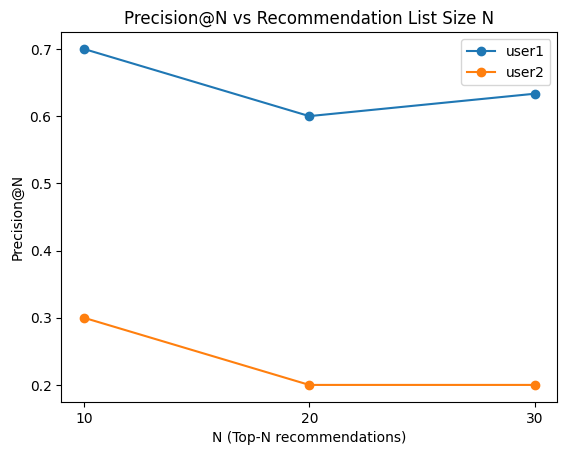

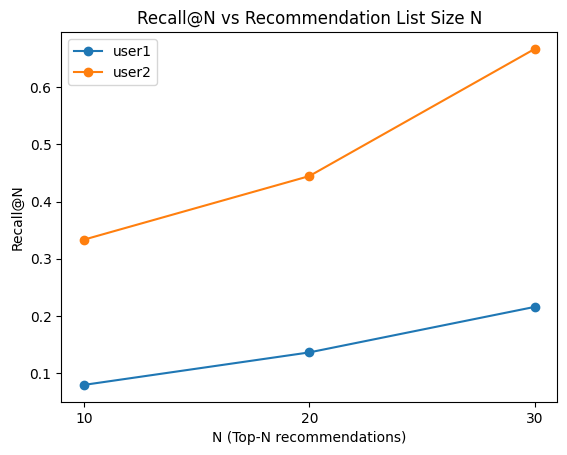

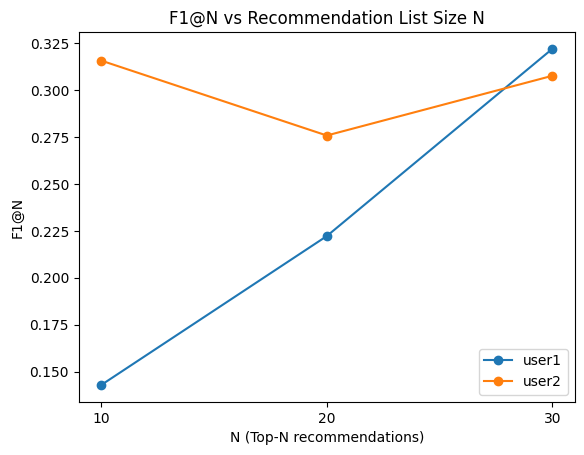

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Parameters
Ns = [10, 20, 30]
algo = 'cosine'
M = 20  # fixed at optimal
results = []

for user in user_keywords:
    # Build single M=20 profile vectors
    user_prof = {}
    for topic, top20 in user_profile_keywords[user].items():
        kws = [w for w, _ in top20[:M]]
        doc = " ".join(kws)
        vect = topic_tfidf[topic]['vectorizer']
        user_prof[topic] = vect.transform([doc])
    
    # Evaluate for different N
    for N in Ns:
        # collect similarity scores
        sim_list = []
        for topic, (indices, X_tfidf) in test_tfidf.items():
            upv = user_prof.get(topic)
            if upv is None:
                continue
            sims = cosine_similarity(X_tfidf, upv).ravel()
            sim_list.extend(zip(indices, sims))
        
        # top-N
        topN = [idx for idx, _ in sorted(sim_list, key=lambda x: x[1], reverse=True)[:N]]
        y_true = [1 if idx in test_likes[user] else 0 for idx in topN]
        
        # metrics
        prec = sum(y_true) / N
        rec = sum(y_true) / len(test_likes[user]) if test_likes[user] else 0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0
        
        results.append({
            'user': user,
            'N': N,
            'Precision@N': prec,
            'Recall@N': rec,
            'F1@N': f1
        })

# Create DataFrame
df_N = pd.DataFrame(results)
print(df_N)

# Plotting
for metric in ['Precision@N', 'Recall@N', 'F1@N']:
    plt.figure()
    for user in df_N['user'].unique():
        sub = df_N[df_N['user'] == user]
        plt.plot(sub['N'], sub[metric], marker='o', label=user)
    plt.title(f'{metric} vs Recommendation List Size N')
    plt.xlabel('N (Top-N recommendations)')
    plt.ylabel(metric)
    plt.xticks(Ns)
    plt.legend()
    plt.show()


___User 1___: F1 rises steadily as N increases and reaches its maximum at N = 30.
___User 2___: F1 is slightly higher at N = 10 than at N = 30 (0.3158 vs. 0.3077), but the difference is small.

If we pick a single N for all users, N = 30 gives the highest average F1 ≈0.315 and also boosts Recall, ensuring better coverage.

__conclusion: set the recommendation list length to 30__

#### 3.Matching Algorithm & M Value Exploration

In [ ]:
Ms = [10, 20, 50, None]       
algorithms = ['cosine','dot','inv_euclid']
N = 30 


In [135]:
# Step 4.2 Training Phase — Feature Extraction & Classifier Training
count_vect = CountVectorizer(preprocessor=preprocess_C, max_features=400)
X_train    = count_vect.fit_transform(train_df['Content'])
clf.fit(X_train, train_df['Category'])

# Step 6.a Predict topic on the test set
test_df['Content_processed'] = test_df['Content'].apply(preprocess_C)
X_test = count_vect.transform(test_df['Content'])      # Note: reuse count_vect here
test_df['predicted_topic'] = clf.predict(X_test)


In [136]:
test_tfidf = {}
for topic, data in topic_tfidf.items():
    vect = data['vectorizer']
    idx = test_df[test_df['predicted_topic'] == topic].index
    docs = test_df.loc[idx, 'Content_processed']
    test_tfidf[topic] = (idx, vect.transform(docs))


In [137]:
test_likes = {}
for user, kw_dict in user_keywords.items():
    likes = set()
    for topic, kws in kw_dict.items():
        df_topic = test_df[test_df['predicted_topic'] == topic]
        mask = df_topic['Content_processed'].apply(
            lambda txt: any(kw in txt.split() for kw in kws)
        )
        likes |= set(df_topic[mask].index)
    test_likes[user] = likes


In [138]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import numpy as np
import pandas as pd

# --- Parameters ---
Ms = [10, 20, 50, None]             # Top-M keywords (None = all)
algorithms = ['cosine', 'dot', 'inv_euclid']
N = 20                              # Recommend top 20 songs

results_list = []

# --- Matching evaluation ---
for user in user_keywords:
    for M in Ms:
        # Build per-topic user profile vectors
        user_profile_vectors = {}
        for topic, top_words in user_profile_keywords[user].items():
            kws = [w for w, _ in top_words[:M]] if M else [w for w, _ in top_words]
            doc = " ".join(kws)
            vect = topic_tfidf[topic]['vectorizer']
            user_profile_vectors[topic] = vect.transform([doc])
        
        for algo in algorithms:
            sim_list = []
            # Compute similarity for all test songs by topic
            for topic, (indices, X_tfidf) in test_tfidf.items():
                upv = user_profile_vectors.get(topic)
                if upv is None:
                    continue
                if algo == 'cosine':
                    sims = cosine_similarity(X_tfidf, upv).ravel()
                elif algo == 'dot':
                    sims = (X_tfidf.multiply(upv)).sum(axis=1).A1
                else:  # inv_euclid
                    dists = pairwise_distances(X_tfidf, upv, metric='euclidean').ravel()
                    sims = 1 / (1 + dists)
                sim_list.extend(zip(indices, sims))
            
            # Select top N
            topN = [idx for idx, _ in sorted(sim_list, key=lambda x: x[1], reverse=True)[:N]]
            # Ground-truth likes in test set
            y_true = [1 if idx in test_likes[user] else 0 for idx in topN]
            
            # Compute metrics
            prec = sum(y_true) / N
            rec = sum(y_true) / len(test_likes[user]) if test_likes[user] else 0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
            
            results_list.append({
                'user': user,
                'algo': algo,
                'M': M or 'all',
                'Precision@20': prec,
                'Recall@20': rec,
                'F1@20': f1
            })

# Create DataFrame of results
results_df = pd.DataFrame(results_list)
results_df


,user,algo,M,Precision@20,Recall@20,F1@20
0,user1,cosine,10,0.55,0.125000,0.203704
1,user1,dot,10,0.55,0.125000,0.203704
2,user1,inv_euclid,10,0.55,0.125000,0.203704
3,user1,cosine,20,0.60,0.136364,0.222222
4,user1,dot,20,0.60,0.136364,0.222222
5,user1,inv_euclid,20,0.60,0.136364,0.222222
6,user1,cosine,50,0.60,0.136364,0.222222
7,user1,dot,50,0.60,0.136364,0.222222
8,user1,inv_euclid,50,0.60,0.136364,0.222222
9,user1,cosine,all,0.60,0.136364,0.222222


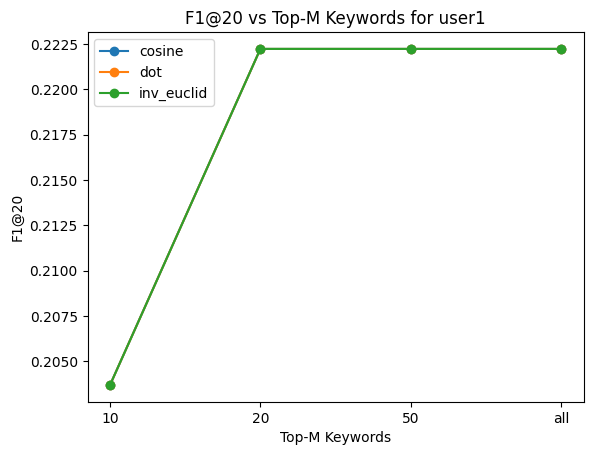

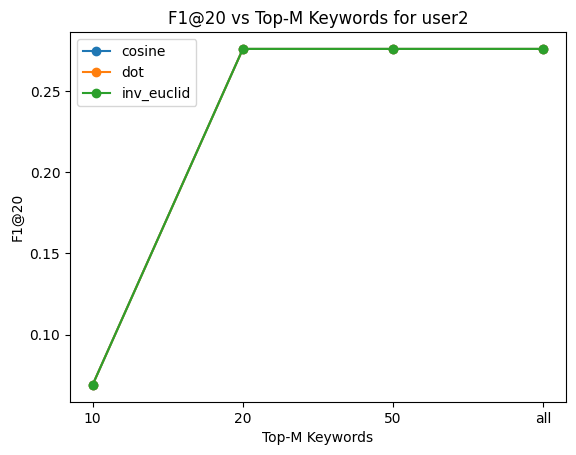

In [139]:
import matplotlib.pyplot as plt

for user in results_df['user'].unique():
    subset = results_df[results_df['user'] == user]
    pivot = subset.pivot(index='M', columns='algo', values='F1@20')

    plt.figure()
    for algo in pivot.columns:
        plt.plot(pivot.index.astype(str), pivot[algo], marker='o', label=algo)
    plt.title(f'F1@20 vs Top-M Keywords for {user}')
    plt.xlabel('Top-M Keywords')
    plt.ylabel('F1@20')
    plt.legend()
    plt.show()


Based on our experiments (see table and F1@20 plots):

___Algorithm Equivalence:___   
Cosine, dot-product, and 1/(1+Euclidean) all produce identical Top-20 rankings—and therefore identical Precision@20, Recall@20, and F1@20—because L2-normalized TF–IDF vectors make these three scoring functions monotonic transforms of one another.

___Precision vs. Recall Trade-off:___   
__Precision@20__ consistently exceeds Recall@20 (e.g. user1: 0.60 vs. 0.136), indicating our Top-20 recommendations are fairly “pure” but still miss many of the user’s liked songs.   
__Recall@20__ jumps substantially when M increases from 10 to 20 (user2: 0.11 → 0.44), showing that richer profiles markedly improve coverage of relevant items.

___Impact of M (Top-M Keywords):___  
__M=10__: too few keywords → both Precision and Recall are low.  
__M=20__: the optimal point—F1@20 peaks here (~0.22 for user1, ~0.28 for user2), balancing purity and coverage.  
M=50 or all: no further F1 improvement; extra keywords simply add noise.

___conclusion___:
Use Cosine similarity with Top-20 keywords per topic. This setup delivers the highest F1@20 while keeping user profiles concise and recommendations focused.

#### 4.conclusion

___Algorithm Equivalence___:   
Cosine, dot-product, and 1/(1+Euclid) yield identical Top-20 rankings (and identical Precision@20, Recall@20, F1@20) on L2-normalized TF–IDF vectors.   
__Stability Across Users:__ Both User 1 (focused) and User 2 (diverse) hit F1 peaks with Cosine + M = 20, showing robustness.   
__Precision vs. Recall:__ Precision@20 always > Recall@20 , so lists are “pure” but miss many likes; Recall jumps from 0.11 → 0.44 when M goes 10 → 20.   

___Impact of M___:
M = 10: too few keywords → low Precision & Recall   
M = 20: optimal F1 peak    
M = 50/all: no F1 gain, just noise   

___Length___:   
User 1’s F1 rises through N = 30; User 2’s F1 is nearly equal at N = 10 & 30   
N = 30 maximizes average F1 (≈0.315) and improves Recall    

___Final Strategy___:  
Algorithm: Cosine similarity  
Profile: Top-20 keywords per topic  
List Length: Top‐30 songs  
Metrics: Precision@N, Recall@N, F1@N  

## part3

1.Preparation 

___Sampling Strategy:___   
__Weeks 1–3:__ Randomly sample 30 songs each week (using random_state=42 for reproducibility) to simulate the user’s “cold-start” interactions.   
__Week 4:__ Retain all songs (751–1000) for the final recommendation evaluation.

In [140]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# ─── Preparation + Preprocessing for Part 3 ─────────────────────────────────────

# 1. Load and merge fields
df = pd.read_csv("dataset.tsv", sep="\t")
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str)     + ' ' +
    df['release_date'].astype(str)   + ' ' +
    df['genre'].astype(str)          + ' ' +
    df['lyrics'].astype(str)
)

# 2. Drop duplicates, drop missing, reset index
df = df.drop_duplicates(subset=['Content']) \
       .dropna(subset=['Content']) \
       .reset_index(drop=True)

# 3. Assign week number (1–4)
df['week'] = df.index // 250 + 1

# 4. Download NLTK resources (once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',    quiet=True)

# 5. Initialize Scheme C cleaner
CLEAN_REGEX = r"[^a-zA-Z0-9#’'\- ]"
tokenizer   = RegexpTokenizer(r"\w+")
stop_words  = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()



List all songs marked “Yes” first, followed by those marked “No”, so the output clearly shows the user's preferences for each week.

In [141]:
import pandas as pd

# 1. Predict topics for Week 1–3 batches and update
for wk in [1, 2, 3]:
    batch = week_batches[wk].copy()
    Xb = count_vect.transform(batch['Content'])
    batch['predicted_topic'] = clf.predict(Xb)
    week_batches[wk] = batch

# 2. Predefine liked indices for each week (example)
liked_indices = {
    1: week_batches[1].index[:8].tolist(),
    2: week_batches[2].index[:12].tolist(),
    3: week_batches[3].index[:5].tolist()
}

# 3. Build interaction table including song info and liked label
records = []
for wk in [1, 2, 3]:
    batch = week_batches[wk]
    for idx, row in batch.iterrows():
        records.append({
            'week': wk,
            'artist': row['artist_name'],
            'track': row['track_name'],
            'predicted_topic': row['predicted_topic'],
            'liked': 'Yes' if idx in liked_indices[wk] else 'No'
        })
inter_df = pd.DataFrame(records)

# 4. Output liked/disliked songs per week
for wk in [1, 2, 3]:
    print(f"\n--- Week {wk}: Liked Songs ---")
    display(inter_df.query("week==@wk and liked=='Yes'")[['artist','track']])
    print(f"--- Week {wk}: Disliked Songs ---")
    display(inter_df.query("week==@wk and liked=='No'")[['artist','track']])



--- Week 1: Liked Songs ---


,artist,track
0,skool 77,vivo hip hop (live)
1,rebelution,trap door
2,alec benjamin,outrunning karma
3,phish,we are come to outlive our brains
4,madeleine peyroux,shout sister shout
5,janiva magness,what i could do
6,eric ethridge,if you met me first
7,imagine dragons,natural


--- Week 1: Disliked Songs ---


,artist,track
8,eli young band,never land
9,larkin poe,john the revelator
10,the movement,fair warning
11,adam jensen,marijuana breath
12,imagine dragons,bullet in a gun
13,jamie n commons,walls
14,311,dodging raindrops
15,cody jinks,i'm not the devil
16,michael franti & spearhead,my lord
17,rend collective,counting every blessing



--- Week 2: Liked Songs ---


,artist,track
30,jon bellion,stupid deep
31,the kills,black tar
32,haken,the good doctor
33,allen toussaint,american tune
34,tenth avenue north,i have this hope
35,surfaces,heaven falls / fall on me
36,blues saraceno,devils got you beat
37,the wood brothers,this is it
38,mild high club,tesselation
39,parov stelar,snake charmer


--- Week 2: Disliked Songs ---


,artist,track
42,ariana grande,make up
43,luke combs,refrigerator door
44,joe corfield,shimmer
45,gary clark jr.,pearl cadillac
46,lanco,greatest love story
47,kings of leon,walls
48,thee oh sees,gelatinous cube
49,melodiesinfonie,tokyo
50,cody jinks,hand me down
51,tesseract,luminary



--- Week 3: Liked Songs ---


,artist,track
60,the score,the fear
61,runaway june,buy my own drinks
62,goodbye june,get happy
63,avril lavigne,head above water
64,shenseea,tie me up


--- Week 3: Disliked Songs ---


,artist,track
65,circa waves,times won’t change me
66,iya terra,...a livication
67,fall out boy,church
68,shane & shane,you’re worthy of it all
69,blues saraceno,the dark horse always wins
70,rex orange county,loving is easy
71,bill charlap trio,there's a small hotel
72,car bomb,secrets within
73,haken,initiate
74,greta van fleet,brave new world
